In [0]:
from os import mkdir
from os import listdir

from shutil import copyfile
from random import shuffle
from tqdm import tqdm

from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.layers import AveragePooling2D, Dropout, Dense, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.metrics import top_k_categorical_accuracy
from keras.utils import  to_categorical

from sklearn.model_selection import train_test_split

from PIL import Image
import base64
import numpy
from io import BytesIO
import cv2

import json
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

%matplotlib inline

snippet para imágenes de google search

```
let obj = {img:[]}
for(let children of document.getElementsByClassName("isv-r PNCib MSM1fd BUooTd")) {
  let src = children.children[0].children[0].children[0].src
  obj.img.push(src)
}
function downloadObjectAsJson(exportObj, exportName){
  var dataStr = "data:text/json;charset=utf-8," + encodeURIComponent(JSON.stringify(exportObj));
  var downloadAnchorNode = document.createElement('a');
  downloadAnchorNode.setAttribute("href",     dataStr);
  downloadAnchorNode.setAttribute("download", exportName + ".json");
  document.body.appendChild(downloadAnchorNode); // required for firefox
  downloadAnchorNode.click();
  downloadAnchorNode.remove();
}
downloadObjectAsJson(obj,"data")
```



In [0]:
def raed_txt(file_name): 
    with open(file_name, 'r') as f: 
        return [l.strip() for l in f]

def read_json(file_name): 
    with open(file_name, 'r') as f: 
        return json.load(f)

def preProcImg(img):
    r,c,x = img.shape
    top = bottom = left = right = 0
    if r < c:
        top = bottom = (c-r)//2
    if r > c:
        left = right = (r-c)//2
    img = cv2.copyMakeBorder(
        img,
        top=top,
        bottom=bottom,
        left=left,
        right=right,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )
    return cv2.resize(img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)

In [0]:
def loadDataset(path):
    images = []
    obj = read_json(path)
    i = 0
    for dataurl in obj["img"]:
        i += 1
        if "," in dataurl:
            image_b64 = dataurl.split(",")[1]
            binary = base64.b64decode(image_b64)
            img = np.asarray(bytearray(binary), dtype="uint8")
            img = cv2.imdecode(img, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if len(img.shape) == 3:
                images.append(preProcImg(img))
        elif len(dataurl) > 0:
            response = requests.get(dataurl)
            img = Image.open(BytesIO(response.content))
            img = np.array(img)
            if len(img.shape) == 3:
                images.append(preProcImg(img))
    print(path, ":", len(images))
    return images

def show_imgs(img_list, nrows=3, ncols=4):
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 6))
    for idx, ax in enumerate(axes.flat):        
        ax.imshow(img_list[idx])
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.grid(False)

In [0]:
files = ["cereza", "durazno", "fresa",
 "lechuga", "limon", "mango",
 "manzana", "maracuya", "naranja",
 "palta", "pera", "piña", "sandia"
 ]
num_classes = len(files)
data = []
labels = []
for i in range(num_classes):
    x = loadDataset(files[i] + ".json")
    y = to_categorical(i, num_classes)
    for d in x:
        data.append(d)
        labels.append(y)

data = np.array(data)
labels = np.array(labels)

cereza.json : 517
durazno.json : 455
fresa.json : 306
lechuga.json : 339
limon.json : 305
mango.json : 302
manzana.json : 316
maracuya.json : 392
naranja.json : 426
palta.json : 267
pera.json : 260
piña.json : 358
sandia.json : 398


In [0]:
data.shape

(4641, 299, 299, 3)

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, shuffle= True)

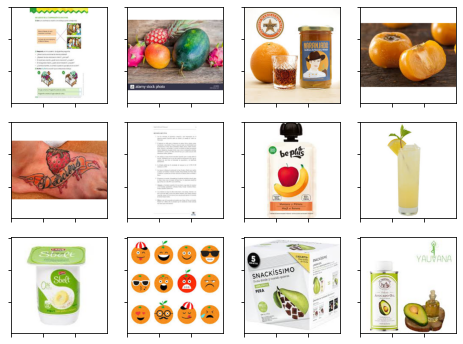

In [0]:
show_imgs(x_train)

#Building model

In [0]:
n_classes = num_classes

base_model = InceptionV3(
    weights='imagenet', 
    include_top=False,
    input_shape=(299,299,3)
)

x = base_model.output 

x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.4)(x)
x = Flatten()(x)

predictions = Dense(n_classes, activation='softmax')(x)    

model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
def step_decay(epoch):
    initial_lr = 1e-2 
    
    if epoch < 9: 
        return initial_lr
    else: 
        return 0.00008

In [0]:
opt = SGD(lr=.01, momentum=.9)

lr_scheduler = LearningRateScheduler(step_decay)
def top_5_accuracy(y_true, y_pred): 
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy', top_5_accuracy]
)

#Train the model

In [0]:
model_file = 'weights.best.InceptionV3_final_model.hdf5'
checkpointer = ModelCheckpoint(filepath=model_file, 
                               verbose=1, save_best_only=True)

In [0]:
%%time

epochs = 2
model.fit(
    x=x_train, y=y_train,
    validation_data=(x_valid, y_valid),
    epochs=epochs,
    callbacks=[checkpointer, lr_scheduler],
    batch_size=32
)

Train on 3712 samples, validate on 929 samples
Epoch 1/2
3712/3712 [==============================] - 1836s 495ms/step - loss: 1.7962 - accuracy: 0.4370 - top_5_accuracy: 0.7866 - val_loss: 3.0230 - val_accuracy: 0.3132 - val_top_5_accuracy: 0.7298

Epoch 00001: val_loss improved from inf to 3.02295, saving model to weights.best.InceptionV3_final_model.hdf5
Epoch 2/2
3712/3712 [==============================] - 1823s 491ms/step - loss: 1.1273 - accuracy: 0.6538 - top_5_accuracy: 0.9060 - val_loss: 2.2034 - val_accuracy: 0.4080 - val_top_5_accuracy: 0.7836

Epoch 00002: val_loss improved from 3.02295 to 2.20345, saving model to weights.best.InceptionV3_final_model.hdf5
CPU times: user 3h 51min 35s, sys: 2min 34s, total: 3h 54min 9s
Wall time: 1h 1min 24s


In [0]:
%%time

epochs = 14
model.fit(
    x=x_train, y=y_train,
    validation_data=(x_valid, y_valid),
    epochs=epochs,
    callbacks=[checkpointer, lr_scheduler],
    batch_size=32
)

Train on 3712 samples, validate on 929 samples
Epoch 1/14
3712/3712 [==============================] - 1822s 491ms/step - loss: 0.8359 - accuracy: 0.7403 - top_5_accuracy: 0.9534 - val_loss: 1.8534 - val_accuracy: 0.4930 - val_top_5_accuracy: 0.8245

Epoch 00001: val_loss improved from 2.20345 to 1.85339, saving model to weights.best.InceptionV3_final_model.hdf5
Epoch 2/14
3712/3712 [==============================] - 1815s 489ms/step - loss: 0.6396 - accuracy: 0.8087 - top_5_accuracy: 0.9744 - val_loss: 2.5749 - val_accuracy: 0.3466 - val_top_5_accuracy: 0.7481

Epoch 00002: val_loss did not improve from 1.85339
Epoch 3/14
3712/3712 [==============================] - 1818s 490ms/step - loss: 0.4480 - accuracy: 0.8629 - top_5_accuracy: 0.9863 - val_loss: 2.0159 - val_accuracy: 0.5016 - val_top_5_accuracy: 0.8138

Epoch 00003: val_loss did not improve from 1.85339
Epoch 4/14
3712/3712 [==============================] - 1819s 490ms/step - loss: 0.3456 - accuracy: 0.8941 - top_5_accuracy: 

In [0]:
model_file = "epoch #16 model.h5"
model.save(model_file)

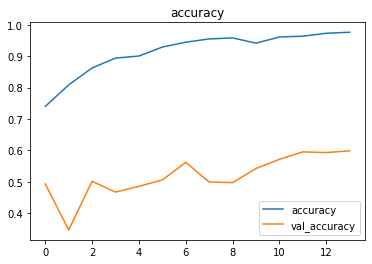

In [0]:
plt.title("accuracy")
plt.plot(model.history.history["accuracy"], label="accuracy")
plt.plot(model.history.history["val_accuracy"], label="val_accuracy")
plt.legend(loc="lower right")
plt.show()

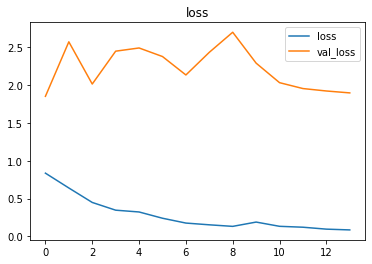

In [0]:
plt.title("loss")
plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"], label="val_loss")
plt.legend(loc="upper right")
plt.show()

In [0]:
i = 20
prediction = model.predict(np.array([x_valid[i]]))[0].round()
print(y_valid[i], prediction)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


#loading model

In [0]:
from keras.models import load_model
classes = ["cereza", "durazno", "fresa",
 "lechuga", "limon", "mango",
 "manzana", "maracuya", "naranja",
 "palta", "pera", "piña", "sandia"
 ]
model_file = "epoch #16 model.h5"

Using TensorFlow backend.


In [0]:
loaded_model = load_model(model_file, custom_objects={"top_5_accuracy": top_5_accuracy})

In [0]:
score = loaded_model.evaluate(x_valid, y_valid, verbose=0)

In [0]:
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 59.85%


In [0]:
import random

class: cereza
prediction: cereza


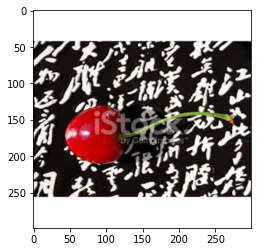

In [0]:
i = random.randint(0, 500)
prediction = loaded_model.predict(np.array([x_valid[i]]))[0]

print("class:", classes[np.argmax(y_valid[i])])
print("prediction:", classes[np.argmax(prediction)])
plt.imshow(x_valid[i])
plt.show()